In [1]:
import numpy as np
import tensorflow as tf
import sys

import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

2022-01-18 12:42:59.380915: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/fvae_miniconda/lib/:
2022-01-18 12:42:59.380980: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sys.path.insert(0,'../')
from scripts.FlowVAEnet import FlowVAEnet
from scripts.utils import listdir_fullpath
from scripts.utils import norm, denorm, convert_to_linear_norm

## Load images

In [3]:
bands = [4,5,6,7,8,9]

######## List of data samples
images_dir = '/sps/lsst/users/barcelin/data/isolated_galaxies/' + '27.5/centered/'
list_of_samples = [x for x in listdir_fullpath(os.path.join(images_dir,'training')) if x.endswith('.npy')]
list_of_samples_val = [x for x in listdir_fullpath(os.path.join(images_dir,'validation')) if x.endswith('.npy')]

# Take 1000 images from the first file.
images = np.load(list_of_samples_val[0],  mmap_mode = 'c')[:1000]

normalization_weights_path = '/sps/lsst/users/barcelin/data/blended_galaxies/' + '27.5/centered/test' 
print("Shape of loaded image" + str(np.shape(images)))

Shape of loaded image(1000, 2, 10, 64, 64)


## Convernt image to linear normalization
Note that the images were non-linearly normalized before being saved. So do denormalization first.

In [4]:
# noisy or blended galaxies
images_noisy_normed = convert_to_linear_norm(images[:, 1, 4:])
images_noisy_normed = np.transpose(images_noisy_normed, axes = (0,2,3,1))

# isolated central galaxies
images_isolated_normed = convert_to_linear_norm(images[:, 0, 4:])
images_isolated_normed = np.transpose(images_isolated_normed, axes = (0,2,3,1))

In [5]:
np.shape(images_isolated_normed)

(1000, 64, 64, 6)

## Load trained models

In [6]:
flow_net = FlowVAEnet(latent_dim=32, linear_norm=True)
flow_net.load_vae_weights(weights_path='/sps/lsst/users/bbiswas/weights/LSST/FlowDeblender/separated_architecture/vae/')
flow_net.load_flow_weights(weights_path='/sps/lsst/users/bbiswas/weights/LSST/FlowDeblender/separated_architecture/fvae/')
print(flow_net.vae_model.summary())

2022-01-18 12:43:20.752593: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/fvae_miniconda/lib/:
2022-01-18 12:43:20.752658: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-18 12:43:20.752695: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2022-01-18 12:43:20.753215: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-0

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.
Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])

2022-01-18 12:43:24.379321: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.



Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0e1847dad0> and <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x7f0e180ee9d0>).
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 6)]       0         
_________________________________________________________________
encoder (Functional)         (None, 560)               3778760   
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 32), (None, 32))  0         
_________________________________________________________________
decoder (Functional)         (None, 64, 64, 6)         4577228   
Total params: 8,355,988
Trainable params: 8,355,976
Non-trainable params: 12
______________________________________________________________

## Test if VAE works

### Looking at image reconstruction

In [7]:
model_vae_output_isolated = flow_net.vae_model(images_isolated_normed)

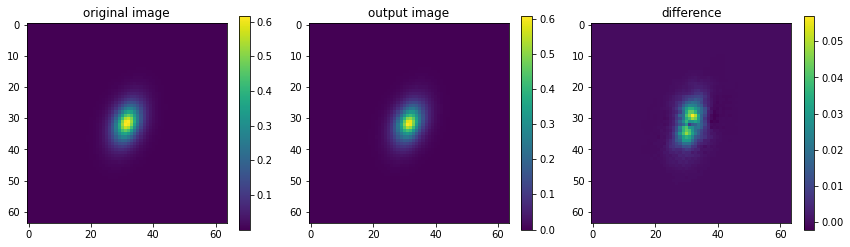

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

image_num = 1

im = axs[0].imshow(images_isolated_normed[image_num][:, :, 2])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("original image")

im = axs[1].imshow(model_vae_output_isolated[0].mean().numpy()[image_num][ :, :, 2])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("output image")


difference = images_isolated_normed[image_num][:, :, 2] - model_vae_output_isolated[0].mean().numpy()[image_num][ :, :, 2]
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2],shrink=0.8)
axs[2].set_title("difference")

plt.tight_layout()

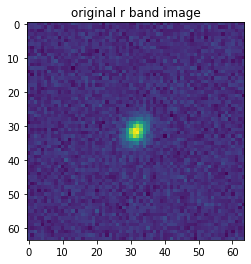

In [9]:
plt.imshow(images_noisy_normed[0][ :, :, 2])
plt.title("original r band image");

## Test if flow network works

The likelihood should be higher for isolated galaxies:

In [10]:
isolated_likelihood = flow_net.flow_model(images_isolated_normed)
noisy_likelihood = flow_net.flow_model(images_noisy_normed)

likelihood_difference=isolated_likelihood-noisy_likelihood

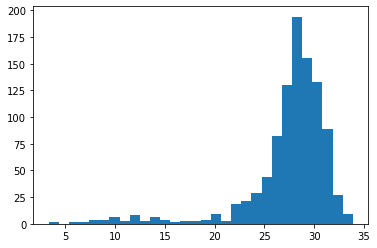

In [11]:
plt.hist(likelihood_difference.numpy(), bins=30);